<a href="https://colab.research.google.com/github/HeNeos/Reports-FIM-UNI/blob/master/MN136-Motores%20de%20Combustion%20Interna/Laboratorio%204/MCI_LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import csv
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
plt.style.use('bmh')
color_maps = [cm.tab10_r, cm.Dark2, cm.Set1]

from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/MyDrive/Colab Notebooks/MCI_LAB4/"

count = 0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [ ]:
def r_squared(coef, x, y):
    yhat = coef(x)
    ybar = np.sum(y)/y.shape[0]
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    return ssreg/sstot

def confidence_band(x):
    return x.std()*np.sqrt(1/x.shape[0] + (x - x.mean())**2 / np.sum((x - x.mean())**2))

def get_latex_string(regression):
    string = "$"
    for i in range(len(regression)+1):
        if i!=0:
            if regression[i] > 0:
                string += "+"
        dig = 5
        if abs(regression[i]) < 1e-5:
            dig = np.log10(abs(regression[i]))
            dig = int(np.ceil(-dig))
        string += str(np.around(regression[i], dig))
        if i != 0:
            string += "x^{"+str(i)+"}"
    string += "$"
    return string
            

def test_plot(grades, x, y, fig, ax, color_map, show, one_color, multi_latex, _loc):
    ax.grid(True)
    latex_title = ""
    for i in grades:
        regression = np.poly1d(np.polyfit(x, y, i))
        r2 = r_squared(regression, x, y)
        nx = np.linspace(np.min(x), np.max(x), 100)
        error = confidence_band(regression(nx))
        value_color = color_map(i)
        if one_color:
            line_type = "-"
            latex_text = get_latex_string(regression)        
        else:
            line_type = "--"
            
        ax.fill_between(nx, regression(nx)-error, regression(nx)+error, alpha=0.12, color=value_color)
        ax.plot(nx, regression(nx), color=value_color, linestyle = line_type, linewidth=2.2, label="$R^{2}$="+str(np.around(r2,5)))
        if one_color:
            if multi_latex:
                latex_title += latex_text
            else:
                ax.set_title(latex_text)
    ax.legend(loc = _loc)
    
    if show:
        ax.scatter(x, y, color=color_map(0), marker="o")
        plt.show()

    if multi_latex:
        return latex_title
    
def motoreo_plot(grades, final_grade, x, y, s_x, s_y):
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    test_plot(grades, x, y, fig, ax[0], color_maps[0], False, False, False, 0)
    ax[0].scatter(x, y, color=color_maps[0](0), marker='o')
    ax[0].set_ylabel(s_y)
    ax[0].set_xlabel(s_x)

    latex_title = ""
    latex_title += test_plot([final_grade], x, y, fig, ax[1], color_maps[0], False, True, True, 0)
    ax[1].set_title(latex_title)
    ax[1].scatter(x, y, color=color_maps[0](0), marker='o')
    ax[1].set_ylabel(s_y)
    ax[1].set_xlabel(s_x)

    #return [i for i in np.poly1d(np.polyfit(x, y, final_grade))]
    return np.poly1d(np.polyfit(x,y, final_grade))

def gen_plot(grades, final_grade, x, y, s_x, s_y):
    fig, ax = plt.subplots(2, len(s_y), figsize=(8*len(s_y), 9))
    
    for i in range(len(s_y)):
        ax[1, i].set_ylabel(s_y[i], color=color_maps[i](0))
        ax[1, i].set_xlabel(s_x)
        ax[1, i].tick_params(axis='y', labelcolor=color_maps[i](0))
        test_plot(grades[i], x, y[i], fig, ax[1, i], color_maps[i], False, False, False, 0)
        
        ax[1, i].scatter(x, y[i], color=color_maps[i](0), marker="o")
        
        ax[0, i].set_ylabel(s_y[i], color=color_maps[i](0))
        ax[0, i].set_xlabel(s_x)
        ax[0, i].tick_params(axis='y', labelcolor=color_maps[i](0))
        test_plot([final_grade[i]], x, y[i], fig, ax[0, i], color_maps[i], False, True, False, 0)

        ax[0, i].scatter(x, y[i], color=color_maps[i](0), marker="X", s=[90 for _ in range(len(x))])
        
    plt.show()

def multiplot(grades, final_grade, x, y, s_x, s_y, _loc):
    global count
    count += 1
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    
    ax[0].set_ylabel(s_y[0], color=color_maps[0](0))
    ax[0].set_xlabel(s_x)
    ax[0].set_ylim(0.95*np.min(y[0]),1.08*np.max(y[0]))
    ax[0].tick_params(axis='y', labelcolor=color_maps[0](0))
    test_plot(grades[0], x, y[0], fig, ax[0], color_maps[0], False, False, False, _loc[0])
    ax[0].scatter(x, y[0], color=color_maps[0](0), marker="o")
        

    for i in range(1, len(s_y)):
        nax = ax[0].twinx()
        if i > 1:
            nax.spines["right"].set_position(("axes", 1.12))
            nax.spines["right"].set_visible(True)
            nax.set_ylim(0.93*np.min(y[i]),1.06*np.max(y[i]))
        else:
            nax.set_ylim(0.9*np.min(y[i]), 1.04*np.max(y[i]))
    
        nax.set_ylabel(s_y[i], color=color_maps[i](0))
        nax.tick_params(axis='y', labelcolor=color_maps[i](0))
        test_plot(grades[i], x, y[i], fig, nax, color_maps[i], False, False, False, _loc[i])
        nax.scatter(x, y[i], color=color_maps[i](0), marker="o")
        nax.grid(False)

    latex_title = ""
    ax[1].set_ylabel(s_y[0], color=color_maps[0](final_grade[0]))
    ax[1].set_xlabel(s_x)
    ax[1].set_ylim(0.9*np.min(y[0]),1.10*np.max(y[0]))
    ax[1].tick_params(axis='y', labelcolor=color_maps[0](final_grade[0]))
    latex_title += test_plot([final_grade[0]], x, y[0], fig, ax[1], color_maps[0], False, True, True, _loc[0]) + '\n'
    ax[1].scatter(x, y[0], color=color_maps[0](final_grade[0]), marker="o")
    
    for i in range(1, len(s_y)):
        nax = ax[1].twinx()
        if i > 1:
            nax.spines["right"].set_position(("axes", 1.12))
            nax.spines["right"].set_visible(True)
            nax.set_ylim(0.85*np.min(y[i]),1.1*np.max(y[i]))
        else:
            nax.set_ylim(0.8*np.min(y[i]), 1.05*np.max(y[i]))
    
        nax.set_ylabel(s_y[i], color=color_maps[i](final_grade[i]))
        nax.tick_params(axis='y', labelcolor=color_maps[i](final_grade[i]))
        latex_title += test_plot([final_grade[i]], x, y[i], fig, nax, color_maps[i], False, True, True, _loc[i]) + '\n'
        nax.scatter(x, y[i], color=color_maps[i](final_grade[i]), marker="o")
        nax.grid(False)

    nax.set_title(latex_title[0:-1])
    fig.tight_layout()

    plt.savefig(dir+"figure"+str(count)+".png", dpi=300)
    plt.show()
    

# Prueba de motoreo

,n (rpm),Fdina (N) - Frio,Fdina (N) - Caliente,Mm (N.m),Nm (kW)
0,300,60,68.0,15.2500,0.479093
1,600,52,60.0,17.6900,1.111495
2,900,44,53.0,19.8250,1.868462
3,1200,38,47.5,21.5025,2.702084
4,1500,33,40.0,23.7900,3.736924


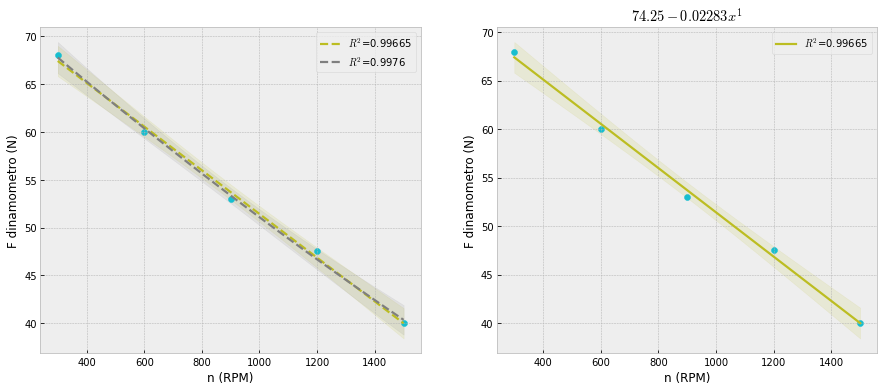

In [ ]:
b = 0.305 #m
W0 = 0.118 #kN

df_motoreo = pd.read_csv(dir + 'motoreo.csv')
df_motoreo['Mm (N.m)'] = b*(W0*1000-df_motoreo['Fdina (N) - Caliente']) #N-m 
df_motoreo['Nm (kW)'] =  (df_motoreo['Mm (N.m)']/1000)*2*np.pi*df_motoreo['n (rpm)']/60 #kW

motoreo_regression = motoreo_plot([1,2], 1, df_motoreo['n (rpm)'], df_motoreo['Fdina (N) - Caliente'], 'n (RPM)', 'F dinamometro (N)')
#motoreo_regression = motoreo_plot([1,2], 1, df_motoreo['n (rpm)'], df_motoreo['Mm (N.m)'], 'n (RPM)', 'F dinamometro (N)')
df_motoreo

# Prueba de velocidad

In [ ]:
t = 15 #s
rho_c = 0.805 #kg/L
P0 = 1.001 #bar
T0 = 299.8 #K
hc = 15 #cm
Hu = 42.5 #MJ/kg
alpha_Ga = 30 #Grades
b = 0.305 #m
lo = 14.3 #kg/kg
W0 = 0.118 #kN
VH = np.pi*(8.73**2)*11/4 #cm^3

#df_velocidad = pd.read_csv('/home/heneos/Downloads/velocidad.csv')
df_velocidad = pd.read_csv(dir + 'velocidad.csv')
df_velocidad

,n(rpm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),Varmadura,Aarmadura,Me (N.m),Ne(kW),Ga(kg/h),Gc(kg/h),lambda,ge(g/kW.h),etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,2000,85,11.8,9.0,11.4,4.95,69,73,46,50,101,45.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1800,87,11.1,7.9,10.1,5.00,70,72,75,40,99,44.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1600,89,9.9,6.0,8.7,1.92,69,72,76,33,94,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1400,86,8.8,4.9,7.4,1.01,70,73,80,28,86,39.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1200,87,7.6,4.3,6.1,0.79,68,71,81,22,81,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1000,82,6.3,3.5,5.0,0.53,69,72,81,18,70,32.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Fd = df_velocidad['F(N)']/1000 #kN
Mm = b*(W0-1e-3*motoreo_regression(df_velocidad['n(rpm)'])) #kN-m
#Mm = motoreo_regression(df_velocidad['n(rpm)'])/1000 #kN-m
Nm = Mm*2*np.pi*df_velocidad['n(rpm)']/60 #kW
pm = 120*Nm/(df_velocidad['n(rpm)']*VH*0.001) #MPa

Me = b*Fd #kN-m
Ne = Me*2*np.pi*df_velocidad['n(rpm)']/60 #kW

pe = 120*Ne/(df_velocidad['n(rpm)']*VH*0.001) #MPa
pi = pm+pe

Ni = Nm+Ne #kW

Gc = 3.6*df_velocidad['V (cm^3)']*rho_c/t #kg/h

eta_i = 3600*Ni/(Hu*1000*Gc)
eta_e = 3600*Ne/(Hu*1000*Gc)
eta_m = Ne/Ni

gi = 1000*Gc/Ni #g/kWh
ge = 1000*Gc/Ne #g/kWh

df_velocidad['Me (N.m)'] = Me*1e3
df_velocidad['Ne(kW)'] = Ne
df_velocidad['Mm (N.m)'] = Mm*1e3
df_velocidad['Nm (kW)'] = Nm
df_velocidad['Gc(kg/h)'] = Gc
df_velocidad['Ni (kW)'] = Ni 
df_velocidad['eta e (%)'] = eta_e
df_velocidad['eta i (%)'] = eta_i
df_velocidad['eta m (%)'] = eta_m
df_velocidad['ge(g/kW.h)'] = ge

df_velocidad

,n(rpm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),Varmadura,Aarmadura,Me (N.m),Ne(kW),Ga(kg/h),Gc(kg/h),lambda,ge(g/kW.h),etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,2000,85,11.8,9.0,11.4,4.95,69,73,46,50,101,45.5,25.925,5.429719,NaN,1.73880,NaN,320.237549,NaN,NaN,0.264510,NaN,NaN,27.272083,5.711852,0.487339,11.141571,0.542763
1,1800,87,11.1,7.9,10.1,5.00,70,72,75,40,99,44.6,26.535,5.001730,NaN,1.52628,NaN,305.150438,NaN,NaN,0.277587,NaN,NaN,25.879250,4.878124,0.506255,9.879853,0.548315
2,1600,89,9.9,6.0,8.7,1.92,69,72,76,33,94,43.0,27.145,4.548188,NaN,1.15920,NaN,254.870708,NaN,NaN,0.332348,NaN,NaN,24.486417,4.102738,0.525746,8.650927,0.632147
3,1400,86,8.8,4.9,7.4,1.01,70,73,80,28,86,39.2,26.230,3.845519,NaN,0.94668,NaN,246.177444,NaN,NaN,0.344085,NaN,NaN,23.093583,3.385696,0.531794,7.231215,0.647026
4,1200,87,7.6,4.3,6.1,0.79,68,71,81,22,81,37.0,26.535,3.334486,NaN,0.83076,NaN,249.141814,NaN,NaN,0.339991,NaN,NaN,21.700750,2.726997,0.550111,6.061483,0.618040
5,1000,82,6.3,3.5,5.0,0.53,69,72,81,18,70,32.2,25.010,2.619041,NaN,0.67620,NaN,258.186100,NaN,NaN,0.328081,NaN,NaN,20.307917,2.126640,0.551879,4.745681,0.594480


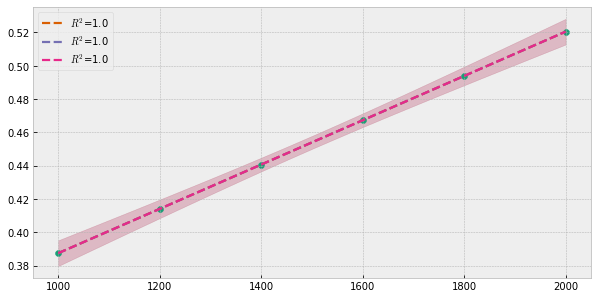

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], df_velocidad['n(rpm)'], pm, fig, ax, cm.Dark2, True, False, False, 0)

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


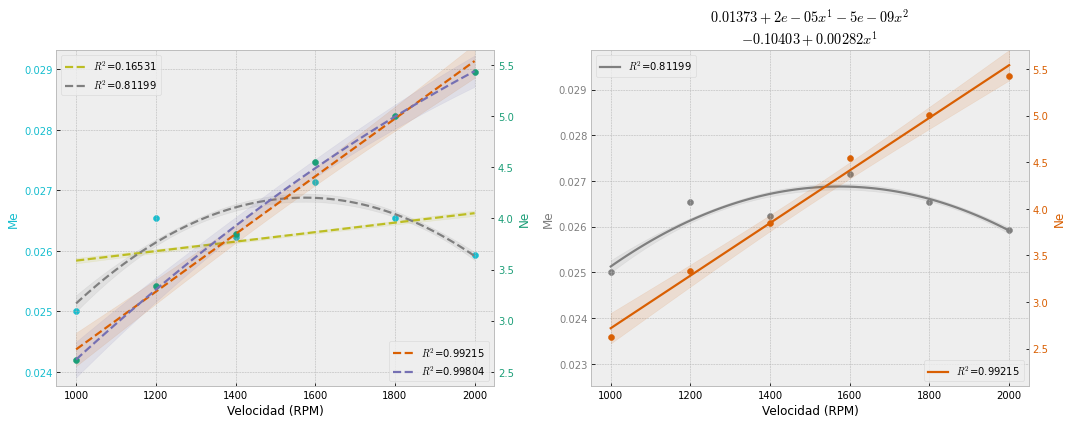

In [ ]:
#gen_plot([[1,2,3,4], [1,2]], [2, 1], df_velocidad['n(rpm)'], [Me, Ne], 'Velocidad (RPM)', ['Me', 'Ne'])
multiplot([[1,2], [1,2]], [2, 1], df_velocidad['n(rpm)'], [Me, Ne], 'Velocidad (RPM)', ['Me', 'Ne'], [2, 4])

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


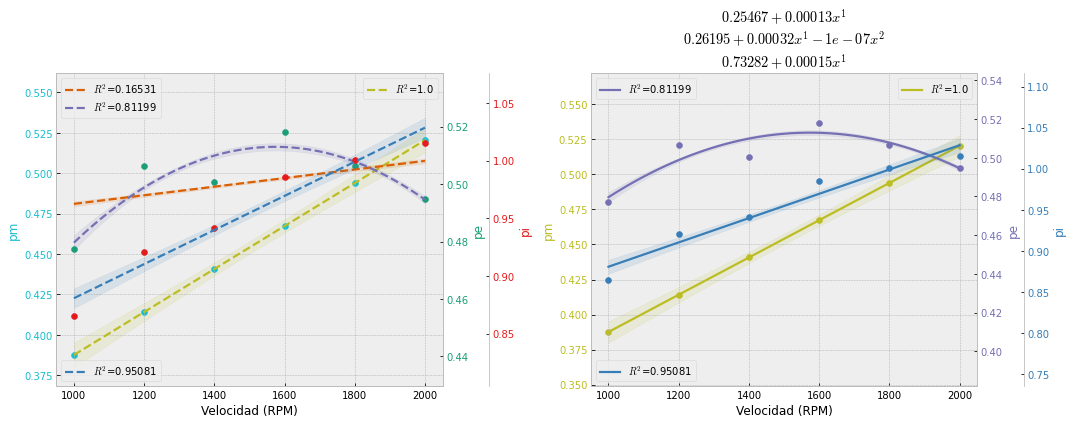

In [ ]:
#gen_plot([[1,2,3], [1,2], [1,2]], [2, 1, 1], df_velocidad['n(rpm)'], [pm, pe, pi], 'Velocidad (RPM)', ['pm', 'pe', 'pi'])
multiplot([[1], [1,2], [1]], [1, 2, 1], df_velocidad['n(rpm)'], [pm, pe, pi], 'Velocidad (RPM)', ['pm', 'pe', 'pi'], [1,2,3])

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


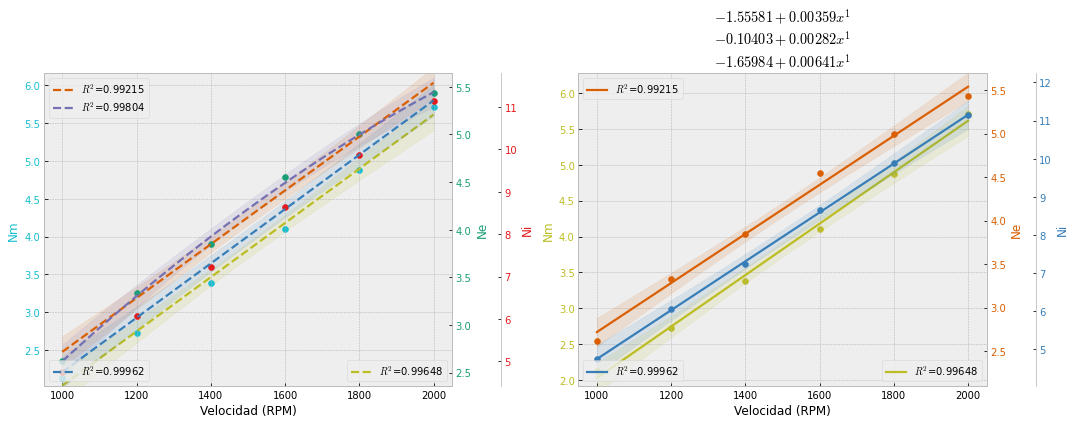

In [ ]:
#gen_plot([[1,2,3], [1,2], [1]], [2, 1, 1], df_velocidad['n(rpm)'], [Nm, Ne, Ni], 'Velocidad (RPM)', ['Nm', 'Ne', 'Ni'])
multiplot([[1], [1,2], [1]], [1, 1, 1], df_velocidad['n(rpm)'], [Nm, Ne, Ni], 'Velocidad (RPM)', ['Nm', 'Ne', 'Ni'], [4,2,3])

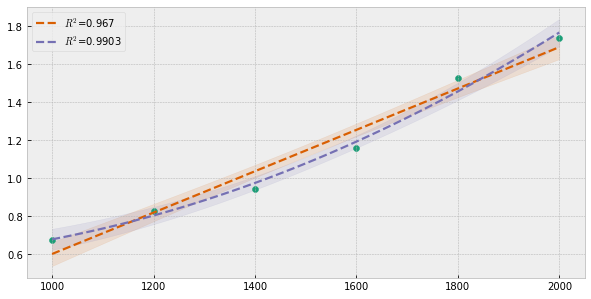

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], df_velocidad['n(rpm)'], Gc, fig, ax, cm.Dark2, True, False, False, 0)

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


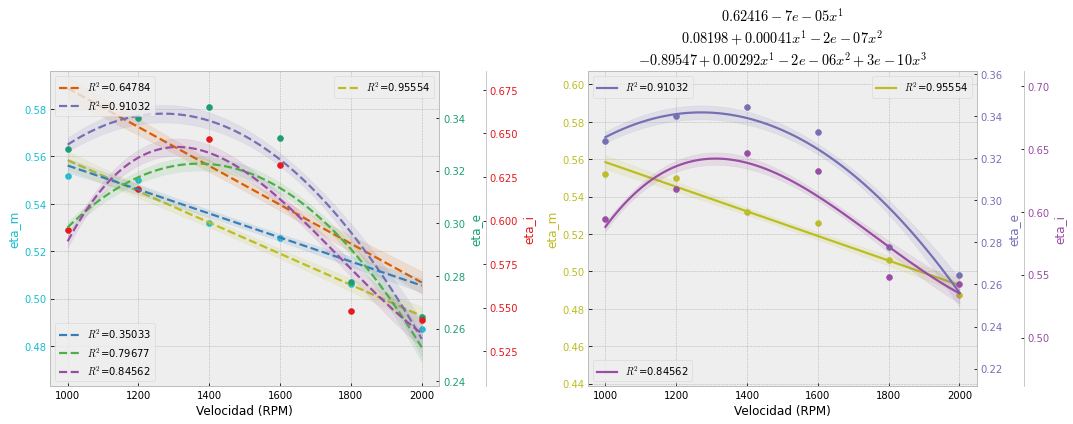

In [ ]:
#gen_plot([[1,2,3,4], [1,2,3], [1,2,3]], [2, 2, 2], df_velocidad['n(rpm)'], [eta_m, eta_e, eta_i], 'Velocidad (RPM)', ['eta_m', 'eta_e', 'eta_i'])
multiplot([[1], [1,2], [1,2,3]], [1, 2, 3], df_velocidad['n(rpm)'], [eta_m, eta_e, eta_i], 'Velocidad (RPM)', ['eta_m', 'eta_e', 'eta_i'], [1,2,3])

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


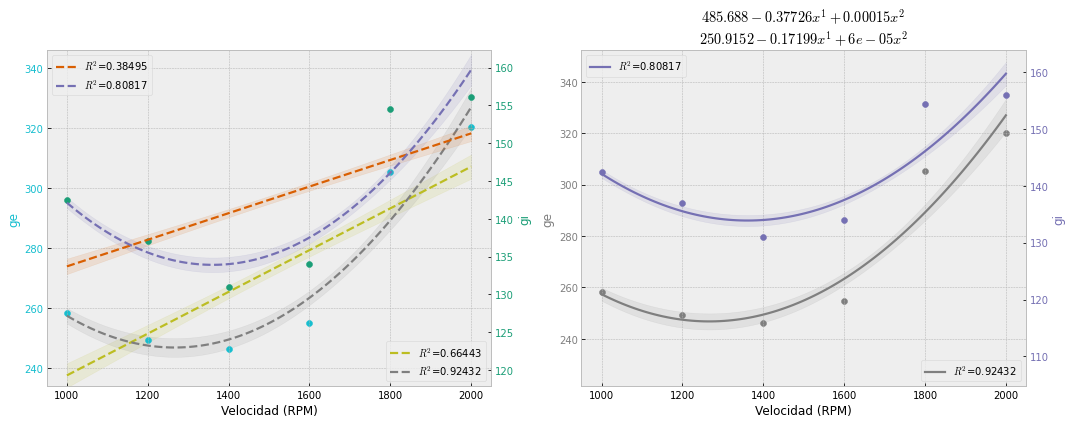

In [ ]:
#gen_plot([[1,2,3], [1,2,3]], [2, 2], df_velocidad['n(rpm)'], [ge, gi], 'Velocidad (RPM)', ['ge', 'gi'])
multiplot([[1,2], [1,2]], [2, 2], df_velocidad['n(rpm)'], [ge, gi], 'Velocidad (RPM)', ['ge', 'gi'], [4, 2])

# Prueba de carga 1

In [ ]:
t = 10 #s
P0 = 1.001 #bar
T0 = 300 #K
n = 1800 #RPM
Hu = 42.5 #MJ/kg
alpha_Ga = 30 #Grades
rho_c = 0.805 #kg/L
b = 0.305 #m

df_carga1 = pd.read_csv(dir+'carga_1.csv')
df_carga1

,hc(cm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),Varmadura,Aarmadura,Me (N.m),Ne(kW),Ga(kg/h),Gc(kg/h),lambda,ge(g/kW.h),etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,15.00,89,10.8,8.1,9.8,4.74,69,72,79.0,39,100,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.25,87,10.8,7.5,10.0,4.25,69,72,81.0,38,97,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.50,83,10.8,7.1,10.0,2.98,70,72,82.0,37,95,43.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.00,71,11.0,5.7,10.2,0.46,70,72,84.0,36,88,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16.50,61,11.0,4.9,10.2,0.30,69,71,85.0,35,80,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,17.00,52,11.0,4.4,10.2,0.32,68,71,86.0,35,74,33.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Fd = df_carga1['F(N)']/1000 #kN
Mm = b*(W0-1e-3*motoreo_regression(n)) #kN-m
Nm = Mm*2*np.pi*n/60 #kW
pm = 120*Nm/(n*VH*0.001) #MPa

Me = b*Fd #kN-m
Ne = Me*2*np.pi*n/60 #kW

pe = 120*Ne/(n*VH*0.001) #MPa
pi = pm+pe

Ni = Nm+Ne #kW

Gc = 3.6*df_carga1['V (cm^3)']*rho_c/t #kg/h

eta_i = 3600*Ni/(Hu*1000*Gc)
eta_e = 3600*Ne/(Hu*1000*Gc)
eta_m = Ne/Ni

gi = 1000*Gc/Ni #g/kWh
ge = 1000*Gc/Ne #g/kWh


df_carga1['Me (N.m)'] = Me*1e3
df_carga1['Ne(kW)'] = Ne
df_carga1['Mm (N.m)'] = Mm*1e3
df_carga1['Nm (kW)'] = Nm
df_carga1['Gc(kg/h)'] = Gc
df_carga1['Ni (kW)'] = Ni 
df_carga1['eta e (%)'] = eta_e
df_carga1['eta i (%)'] = eta_i
df_carga1['eta m (%)'] = eta_m
df_carga1['ge(g/kW.h)'] = ge

df_carga1

,hc(cm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),Varmadura,Aarmadura,Me (N.m),Ne(kW),Ga(kg/h),Gc(kg/h),lambda,ge(g/kW.h),etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,15.00,89,10.8,8.1,9.8,4.74,69,72,79.0,39,100,45.0,27.145,5.116712,NaN,2.34738,NaN,458.767275,NaN,NaN,0.184638,NaN,NaN,25.87925,4.878124,0.511936,9.994836,0.360667
1,15.25,87,10.8,7.5,10.0,4.25,69,72,81.0,38,97,44.0,26.535,5.001730,NaN,2.17350,NaN,434.549675,NaN,NaN,0.194928,NaN,NaN,25.87925,4.878124,0.506255,9.879853,0.385039
2,15.50,83,10.8,7.1,10.0,2.98,70,72,82.0,37,95,43.4,25.315,4.771765,NaN,2.05758,NaN,431.198931,NaN,NaN,0.196443,NaN,NaN,25.87925,4.878124,0.494489,9.649889,0.397264
3,16.00,71,11.0,5.7,10.2,0.46,70,72,84.0,36,88,40.0,21.655,4.081871,NaN,1.65186,NaN,404.682035,NaN,NaN,0.209315,NaN,NaN,25.87925,4.878124,0.455566,8.959995,0.459460
4,16.50,61,11.0,4.9,10.2,0.30,69,71,85.0,35,80,36.7,18.605,3.506960,NaN,1.42002,NaN,404.914812,NaN,NaN,0.209194,NaN,NaN,25.87925,4.878124,0.418238,8.385084,0.500180
5,17.00,52,11.0,4.4,10.2,0.32,68,71,86.0,35,74,33.8,15.860,2.989540,NaN,1.27512,NaN,426.527219,NaN,NaN,0.198594,NaN,NaN,25.87925,4.878124,0.379978,7.867663,0.522647


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


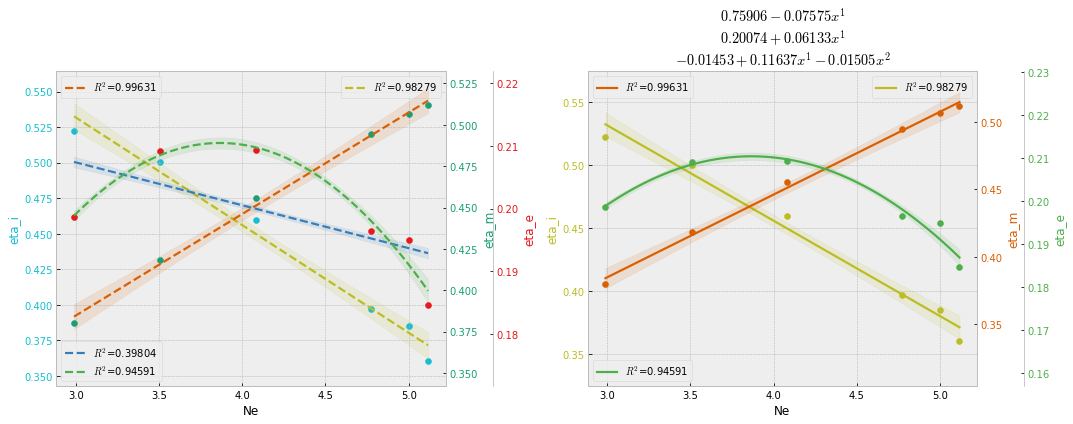

In [ ]:
#gen_plot([[1,2], [1], [1,2,3]], [1, 1, 2], Ne, [eta_i, eta_m, eta_e], 'Ne', ['eta_i', 'eta_m', 'eta_e'])
multiplot([[1], [1], [1,2]], [1, 1, 2], Ne, [eta_i, eta_m, eta_e], 'Ne', ['eta_i', 'eta_m', 'eta_e'], [1,2,3])

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


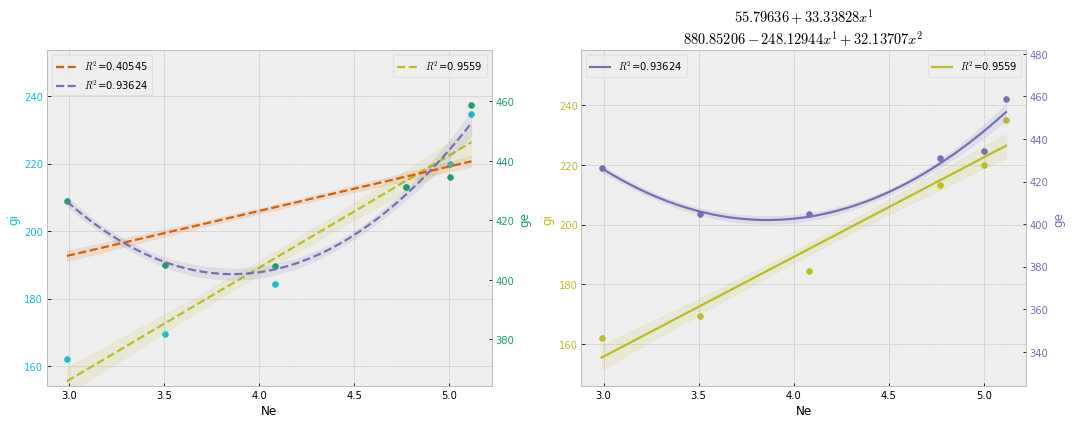

In [ ]:
#gen_plot([[1,2], [1,2,3]], [2, 2], Ne, [gi, ge], 'Ne', ['gi', 'ge'])
multiplot([[1], [1,2]], [1, 2], Ne, [gi, ge], 'Ne', ['gi', 'ge'], [1,2])

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


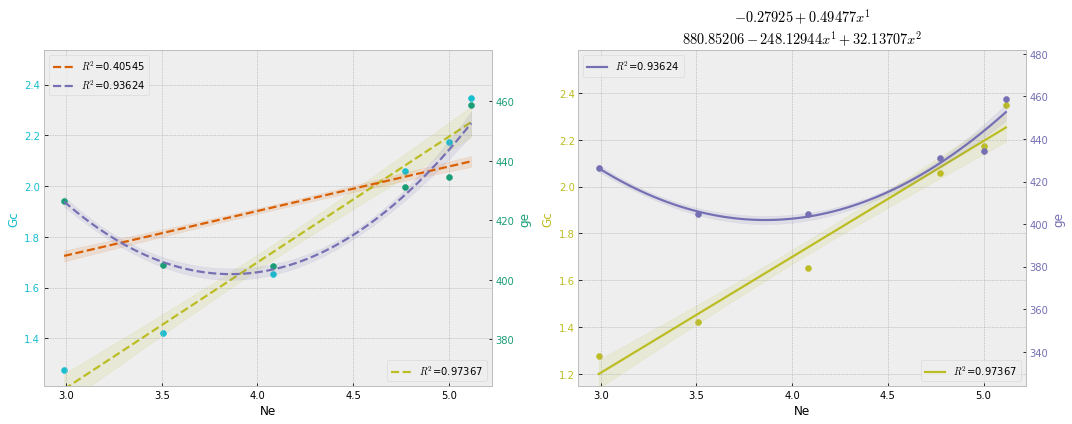

In [ ]:
#gen_plot([[1,2], [1,2,3]], [2, 2], Ne, [Gc, ge], 'Ne', ['Gc', 'ge'])
multiplot([[1], [1,2]], [1, 2], Ne, [Gc, ge], 'Ne', ['Gc', 'ge'], [4,2])

# Prueba de carga 2

In [ ]:
t = 10 #s
P0 = 1.001 #bar
T0 = 300 #K
n = 1200 #RPM
Hu = 42.5 #MJ/kg
alpha_Ga = 30 #Grades
rho_c = 0.805 #kg/L
b = 0.305 #m

df_carga2 = pd.read_csv(dir + 'carga_2.csv')
df_carga2

,hc(cm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),Varmadura,Aarmadura,Me (N.m),Ne(kW),Ga(kg/h),Gc(kg/h),lambda,ge(g/kW.h),etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,15.00,91,7.3,4.4,6.0,0.97,68,70,81.0,24.0,83,37.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.25,86,7.4,4.2,6.1,0.74,70,72,82.0,23.5,81,36.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.50,81,7.3,3.8,6.0,0.49,69,72,82.0,23.0,78,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.00,66,7.3,3.2,6.1,0.52,69,71,82.0,23.0,70,31.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16.50,56,7.4,2.8,6.1,0.51,69,71,82.0,23.5,63,28.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Fd = df_carga2['F(N)']/1000 #kN
Mm = b*(W0-1e-3*motoreo_regression(n)) #kN-m
Nm = Mm*2*np.pi*n/60 #kW
pm = 120*Nm/(n*VH*0.001) #MPa


Me = b*Fd #kN-m
Ne = Me*2*np.pi*n/60 #kW

pe = 120*Ne/(n*VH*0.001) #MPa
pi = pm+pe

Ni = Nm+Ne #kW

Gc = 3.6*df_carga2['V (cm^3)']*rho_c/t #kg/h

eta_i = 3600*Ni/(Hu*1000*Gc)
eta_e = 3600*Ne/(Hu*1000*Gc)
eta_m = Ne/Ni

gi = 1000*Gc/Ni #g/kWh
ge = 1000*Gc/Ne #g/kWh


df_carga2['Me (N.m)'] = Me*1e3
df_carga2['Ne(kW)'] = Ne
df_carga2['Mm (N.m)'] = Mm*1e3
df_carga2['Nm (kW)'] = Nm
df_carga2['Gc(kg/h)'] = Gc
df_carga2['Ni (kW)'] = Ni 
df_carga2['eta e (%)'] = eta_e
df_carga2['eta i (%)'] = eta_i
df_carga2['eta m (%)'] = eta_m
df_carga2['ge(g/kW.h)'] = ge

df_carga2

,hc(cm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),Varmadura,Aarmadura,Me (N.m),Ne(kW),Ga(kg/h),Gc(kg/h),lambda,ge(g/kW.h),etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,15.00,91,7.3,4.4,6.0,0.97,68,70,81.0,24.0,83,37.8,27.755,3.487796,NaN,1.27512,NaN,365.594760,NaN,NaN,0.231693,NaN,NaN,21.70075,2.726997,0.561209,6.214793,0.412847
1,15.25,86,7.4,4.2,6.1,0.74,70,72,82.0,23.5,81,36.6,26.230,3.296159,NaN,1.21716,NaN,369.266166,NaN,NaN,0.229390,NaN,NaN,21.70075,2.726997,0.547248,6.023156,0.419170
2,15.50,81,7.3,3.8,6.0,0.49,69,72,82.0,23.0,78,35.1,24.705,3.104522,NaN,1.10124,NaN,354.721290,NaN,NaN,0.238796,NaN,NaN,21.70075,2.726997,0.532369,5.831519,0.448552
3,16.00,66,7.3,3.2,6.1,0.52,69,71,82.0,23.0,70,31.8,20.130,2.529610,NaN,0.92736,NaN,366.601908,NaN,NaN,0.231057,NaN,NaN,21.70075,2.726997,0.481225,5.256607,0.480143
4,16.50,56,7.4,2.8,6.1,0.51,69,71,82.0,23.5,63,28.8,17.080,2.146336,NaN,0.81144,NaN,378.058217,NaN,NaN,0.224055,NaN,NaN,21.70075,2.726997,0.440425,4.873333,0.508725


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


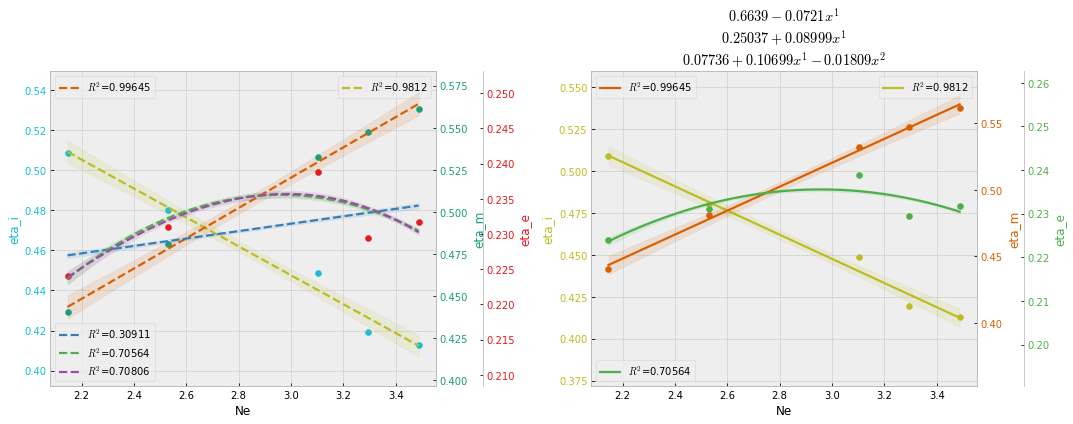

In [ ]:
#gen_plot([[1,2], [1], [1,2,3]], [1, 1, 2], Ne, [eta_i, eta_m, eta_e], 'Ne', ['eta_i', 'eta_m', 'eta_e'])
multiplot([[1], [1], [1,2,3]], [1, 1, 2], Ne, [eta_i, eta_m, eta_e], 'Ne', ['eta_i', 'eta_m', 'eta_e'], [1,2,3])

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


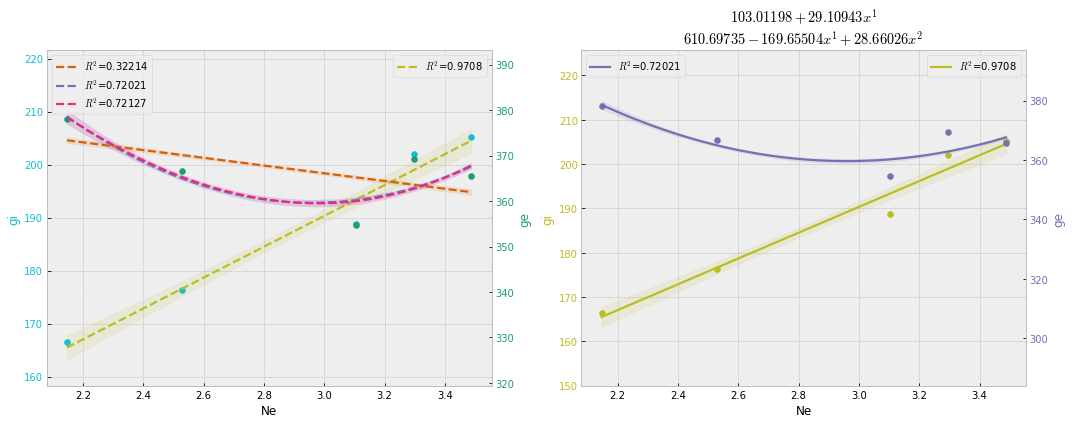

In [ ]:
#gen_plot([[1,2], [1,2,3]], [2, 2], Ne, [gi, ge], 'Ne', ['gi', 'ge'])
multiplot([[1], [1,2,3]], [1, 2], Ne, [gi, ge], 'Ne', ['gi', 'ge'], [1,2])

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


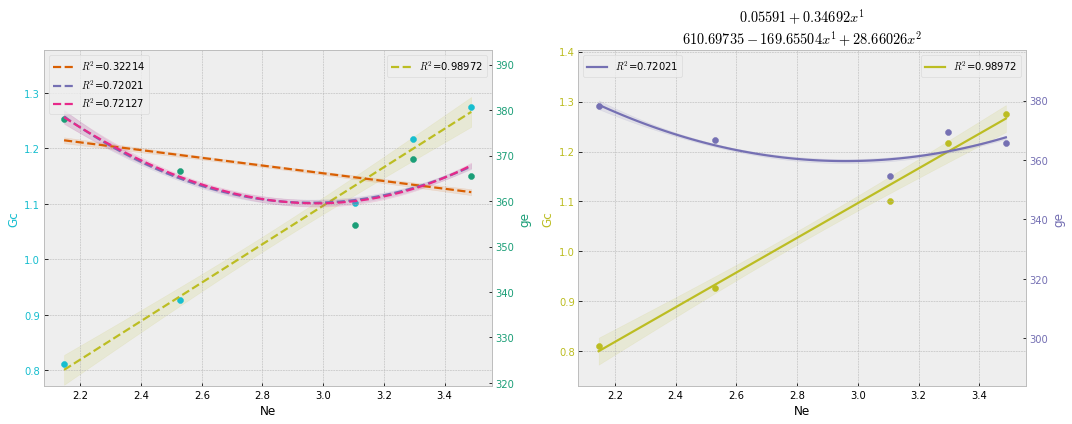

In [ ]:
#gen_plot([[1,2], [1,2,3]], [2, 2], Ne, [Gc, ge], 'Ne', ['Gc', 'ge'])
multiplot([[1], [1,2,3]], [1, 2], Ne, [Gc, ge], 'Ne', ['Gc', 'ge'], [1,2])